In [ ]:
# 目前 finetune 的 loss 還是 CrossEntropyLoss
# 之後在研究用 triplesLoss

In [1]:
import cv2
import time
import matplotlib.pyplot as plt
from faceapi import FaceAPIManager

from PIL import Image
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

from faceapi.faceEmbeddimg.facenet.models.mtcnn import fixed_image_standardization
from faceapi.faceEmbeddimg.facenet.models.inception_resnet_v1 import InceptionResnetV1
from faceapi.faceEmbeddimg.facenet.models.utils import training

In [4]:
face_api_manager = FaceAPIManager(
    detector_model_path='model_weights/face-yolov8-m.pt',
    encoder_model_path=None,
)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

device: cuda:0


In [6]:
# 要訓練的資料集
data_dir = 'data/feifei-face'
batch_size = 32
workers = 0 if os.name == 'nt' else 8

In [ ]:
# 用 camera 新增臉

In [ ]:
output_face_path =  'data/feifei-face/gy'

if not os.path.isdir(output_face_path):
    os.makedirs(output_face_path)

In [ ]:
cap = cv2.VideoCapture(1)

In [ ]:
while 1:
    d, frame = cap.read()
    if not d:
        print('no image')
        break

    display_frame = frame.copy()
    face_res = face_api_manager._detector.handle(frame)
    for face in face_res:
        x1,y1,x2,y2  = face.xyxy  
        #reid = reid_encoder.inference(img, np.array(face.xyxy)[None]).ravel()
        cv2.rectangle(display_frame, ( x1,y1), (x2,y2), (255, 255, 255))
    
    cv2.imshow("camera", display_frame)

    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # q to quit
        print('Quit')
        break
    elif key == ord('s'):  # q to quit
        face_img = frame[y1:y2,x1:x2,:]
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        f_img = Image.fromarray(face_img).resize((160,160))
        save_file = os.path.join(output_face_path, f"{len(os.listdir(output_face_path))}.jpeg")
        f_img.save(save_file)
        print(f'save_file : {save_file}')
    

cv2.destroyAllWindows()

In [ ]:
#  將訓練資料切出臉

In [7]:
dataset = datasets.ImageFolder(data_dir)
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

In [8]:
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

### 切臉-如果切過臉可以跳過

In [ ]:
for i, (x, y) in enumerate(loader):
    
    for idx in range(len(x)):
        img = np.array(x[idx])
        face_res = face_api_manager._detector.handle(img)
        if len(face_res) == 0:
            continue
        face = face_res[0]
        x1,y1,x2,y2  = face.xyxy
        face_img = img[y1:y2,x1:x2,:]
        f_img = Image.fromarray(face_img).resize((160,160))
        outpath_path = os.path.dirname(y[idx])
        if not os.path.isdir(outpath_path):
            os.makedirs(outpath_path)
        f_img.save(y[idx])

In [9]:
# 要finetune 的
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

print(dataset.class_to_idx)

{'boss': 0, 'chairman': 1, 'director': 2, 'gy': 3, 'joneshong': 4, 'master': 5, 'mayor': 6, 'undersecretary': 7}


定義 optimizer

In [10]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)


# 發現如果資料集不多，那就全上
# train_inds = img_inds[:int(0.8 * len(img_inds))]
# val_inds = img_inds[int(0.8 * len(img_inds)):]

train_inds = img_inds
val_inds = img_inds

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    # sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    # sampler=SubsetRandomSampler(val_inds)
)

定義 loss

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

# 開始finetune

In [12]:
epochs = 20

In [13]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('epoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

Valid |     3/3    | loss:    2.0510 | fps:   64.9041 | acc:    0.3750   
\epoch 1/20
----------
Train |     3/3    | loss:    2.0966 | fps:   64.8127 | acc:    0.0417   
Valid |     3/3    | loss:    2.1682 | fps:  228.2181 | acc:    0.0938   
\epoch 2/20
----------
Train |     3/3    | loss:    2.0382 | fps:  105.5612 | acc:    0.2396   
Valid |     3/3    | loss:    2.0699 | fps:  206.1583 | acc:    0.1875   
\epoch 3/20
----------
Train |     3/3    | loss:    1.8796 | fps:  166.9318 | acc:    0.4167   
Valid |     3/3    | loss:    1.9027 | fps:  132.0444 | acc:    0.3125   
\epoch 4/20
----------
Train |     3/3    | loss:    1.7122 | fps:  142.4142 | acc:    0.5938   
Valid |     3/3    | loss:    1.7437 | fps:  215.0382 | acc:    0.5521   
\epoch 5/20
----------
Train |     3/3    | loss:    1.5814 | fps:   95.8754 | acc:    0.6979   
Valid |     3/3    | loss:    1.6691 | fps:  194.8661 | acc:    0.6458   
\epoch 6/20
----------
Train |     3/3    | loss:    1.4979 | fps:  131

# 存下權重

In [14]:
save_weight = {}
save_weight["weight"] = resnet.state_dict()
save_weight['class_to_idx'] = dataset.class_to_idx

In [15]:
# Save model checkpoint
torch.save(save_weight, 'model_weights/feifei_face.pt')

# 測試剛剛訓練的模型

In [16]:
face_api_manager = FaceAPIManager(
    detector_model_path='model_weights/face-yolov8-m.pt',
    encoder_model_path='model_weights/feifei_face.pt',
)

loaded finetune model , output to 8


In [24]:
# img_file = r'C:/Users/jeffg/face-project/Pytorch_Retinaface/data/FDDB/images/2002/12/10/big/img_410.jpg'
# img_file = r'C:\Users\jeffg\ai-data\face-database\classify - 複製\9\64fc0389b6db50bc1f756e0e-166-4154.png'
img_file = r'data/feifei-face/gy/0541810.jpg'
# img_file = r'C:/Users/jeffg/Desktop/test.jpg'

WARNING ⚠️ imgsz=[1087, 798] must be multiple of max stride 32, updating to [1088, 800]
gy 0.99974686


0.4919915199279785

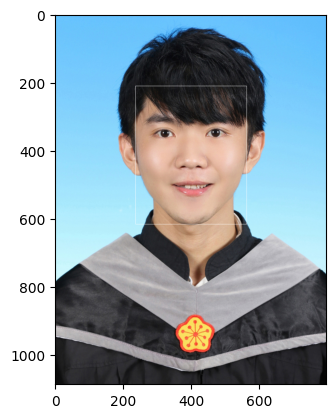

In [27]:
img = cv2.imread(img_file, cv2.IMREAD_COLOR)#
display_img = img.copy()


st = time.time()
faces = face_api_manager.handle(img, conf=0.5)
for face in faces:
    pred_idx = face.embedding.argmax()
    pred_prob = face.embedding[pred_idx]
    print({
       v: k
       for k , v in face_api_manager._encoder._model.class_to_idx.items()
    }[pred_idx], pred_prob)
    
    x1,y1,x2,y2  = face.xyxy  
    #reid = reid_encoder.inference(img, np.array(face.xyxy)[None]).ravel()
    cv2.rectangle(display_img, ( x1,y1), (x2,y2), (255, 255, 255))
#embeddings = face_embedder.handle(face_img_list)
plt.imshow(display_img[..., ::-1])

cost = time.time() -st
cost

# Test By Camera

In [34]:
cap = cv2.VideoCapture(1)

In [35]:
while 1:
    d, frame = cap.read()
    if not d:
        print('no image')
        break

    display_frame = frame.copy()
    faces = face_api_manager.handle(frame, conf=0.5)
    for face in faces:
        pred_idx = face.embedding.argmax()
        pred_prob = face.embedding[pred_idx]
        label = {
           v: k
           for k , v in face_api_manager._encoder._model.class_to_idx.items()
        }[pred_idx]
        
        #print(label, pred_prob)
        x1,y1,x2,y2  = face.xyxy  
        
        cv2.putText(display_frame, f"%s - %.2f"%(label, pred_prob), (x1, y1),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
        cv2.rectangle(display_frame, ( x1,y1), (x2,y2), (255, 255, 255))
    
    cv2.imshow("camera", display_frame)

    
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):  # q to quit
        print('Quit')
        break
        
cv2.destroyAllWindows()
cap.release()

Quit
